# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***



# OBTAIN

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***


Importing packages for importing data and exploratory visual analysis.

In [138]:
import pandas as pd
import seaborn as sns
# sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
import numpy as np

## Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn import metrics

## Models & Utils
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings(action='ignore') 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix

In [185]:
# Visualize the impact of a few key metrics on Hall of Fame inclusivity 
def comparative_graph(s):
    cat, num = 'inducted', s
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=(20, 7))
    fig.suptitle(s + ' vs Inducted', fontsize=20)

    # Create a distribution graph to compare HOF inducted players against those not inducted by a certain metric.
    ax[0].title.set_text('density')
    for i in df[cat].unique():
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    
    # Create a stacked bar graph containing 10 bins to help visualize the divide between the two classes of players.
    ax[1].title.set_text('bins')
    breaks = np.quantile(df[num], q=np.linspace(0,1,11))
    tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
         tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
    
    # Create a boxplot to compare HOF inducted players against those not inducted and to visualize outliers.   
    ax[2].title.set_text('outliers')
    sns.boxplot(x=cat, y=num, data=df, ax=ax[2])
    ax[2].grid(True)
    plt.savefig(s)
    plt.show();

    
# Create a new correlated dataframe with absolute value of a number,
def high_corr(df):
    df_highcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_highcorr['Highly Correlated Pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
    df_highcorr.set_index(['Highly Correlated Pairs'], inplace = True)
    df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
    df_highcorr.columns = ['Correlation']
    df_highcorr.drop_duplicates(inplace=True)
    return df_highcorr[(df_highcorr.Correlation>.7) & (df_highcorr.Correlation<1)]
    
# Create function used to find Precision, Recall, Accuracy, and F1 Scores.
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
# Find the optimal K value for KNN models.
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k 
            best_score = f1
            
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

# Create a function that visualizes the confusion matrix for the model.    
def plot_cm(model, normalize='true'):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.grid(False)
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax, normalize=normalize)
    
# Create function for performing log transformations.
def log_transform(df,features):
    '''Runs a log transformation on a feature
    
        @params
        df is a pd.Dataframe
        features is a list of columns to be considered
        
        @output
        new log-transformed column
    
    '''
    for feature in features:
        df[feature + '_log'] = np.log(df[feature]+1)
    return df 

In [140]:
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [141]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [143]:
df.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


<AxesSubplot:>

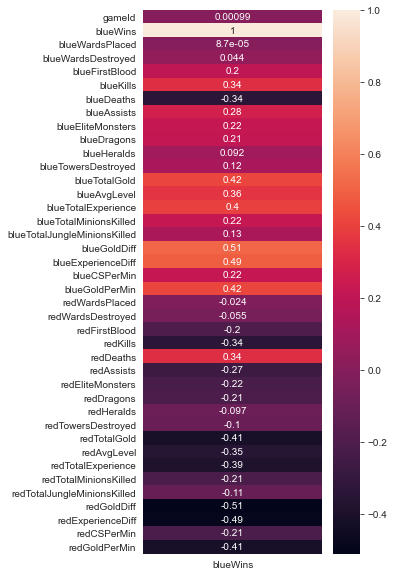

In [144]:
fig = plt.figure(figsize=(4, 10))
sns.heatmap(df.corr()[['blueWins']], annot=True)

<AxesSubplot:xlabel='blueGoldDiff', ylabel='Count'>

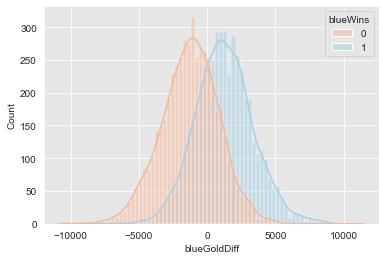

In [145]:
sns.histplot(x='blueGoldDiff', data=df, hue='blueWins', palette='RdBu', kde=True)

<AxesSubplot:xlabel='blueKills', ylabel='Count'>

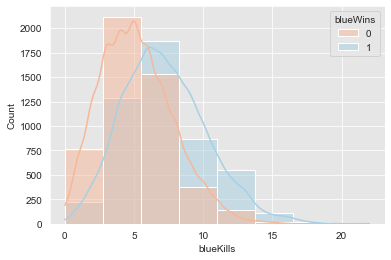

In [146]:
sns.histplot(x='blueKills', data=df, hue='blueWins', palette='RdBu', kde=True, bins=8)

# SCRUB

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

After initial data understanding, we are confident that the data we're using is sound.  No NA or missing values were discovered.

Let's take a look at the columns:

In [147]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

There are a few columns that can be removed entirely and a few that can be combined into categorical variables.

### First Blood

'First Blood' is awarded to the team who gets the first kill in the game.  Both blueFirstBlood and redFirstBlood are binary and inversely related.  If Blue wins First Blood, blueFirstBlood will be recorded as 1 and redFirstBlood will be recorded as 0.  

We can merge these columns into one.

In [148]:
df['blueFirstBlood']

0       1
1       0
2       0
3       0
4       0
       ..
9874    1
9875    0
9876    0
9877    1
9878    1
Name: blueFirstBlood, Length: 9879, dtype: int64

In [149]:
firstBlood = []

for item in df['blueFirstBlood']:
    if item == 1:
        firstBlood.append('Blue')
    else:
        firstBlood.append('Red')
        
df['firstBlood'] = firstBlood

df['firstBlood']

0       Blue
1        Red
2        Red
3        Red
4        Red
        ... 
9874    Blue
9875     Red
9876     Red
9877    Blue
9878    Blue
Name: firstBlood, Length: 9879, dtype: object

We can discard blueFirstBlood and redFirstBlood

In [150]:
del df['blueFirstBlood']
del df['redFirstBlood']

### Kills & Deaths

blueKills is inversely related with redDeaths, and redKills is inversely related with blueDeaths since the Blue team can only kill Red players and vice versa.  blueDeaths and redDeaths can both be removed, leaving kills intact will preserve this information.

In [151]:
del df['blueDeaths']
del df['redDeaths']

### Dragon & Herald

While this wouldn't hold true for LoL data spanning the entire length of each game, we know that there is only one opportunity to kill both the Dragon and the Harold in the first 10 minutes of each match.  Unlike firstBlood where the action always occurs in the first 10 minutes (at least for the matches in our dataset), each dragon or herald can be killed only once or not at all.

Therefore, dragon and herald can be categorized as 'Blue,' 'Red,' or 'None.'

In [152]:
dragon_list = []

dragon_kill = df['blueDragons'] - df['redDragons']

for item in dragon_kill:
    if item == 1:
        dragon_list.append('Blue')
    elif item == -1:
        dragon_list.append('Red')
    else:
        dragon_list.append('No Dragon')
        
df['dragon'] = dragon_list

blueDragons and redDragons can be removed:

In [153]:
del df['blueDragons']
del df['redDragons']

We can reuse this code for the herald feature:

In [154]:
herald_list = []

herald_kill = df['blueHeralds'] - df['redHeralds']

for item in herald_kill:
    if item == 1:
        herald_list.append('Blue')
    elif item == -1:
        herald_list.append('Red')
    else:
        herald_list.append('No Herald')
        
df['herald'] = herald_list

In [155]:
del df['blueHeralds']
del df['redHeralds']

### Elite Monsters

In [156]:
del df['blueEliteMonsters']
del df['redEliteMonsters']

### GoldDiff, ExperienceDiff, CSPerMin, and GoldPerMin

Both blue and red teams have these four metrics.  While they are useful metrics for other types of analyses, they are essentially duplicative, since they are all calculated in a similar fashion from features already included in our data.  

- GoldDiff represents the difference between blueTotalGold and redTotalGold
- ExperienceDiff represents the difference between blueTotalExperience and redTotalExperience
- blue and red CSPerMin represents the minute rate of blue and red TotalMinionsKilled.  For our 10 minute data, CSPerMin for each team will always be TotalMinionsKilled divided by 10
- similarly, blue and red GoldPerMin represents blue and red TotalGold divided by 10

These four features from both teams (totaling 8 features) can be removed without losing any information.


In [157]:
del df['blueGoldDiff']
del df['blueExperienceDiff']
del df['blueCSPerMin']
del df['blueGoldPerMin']
del df['redGoldDiff']
del df['redExperienceDiff']
del df['redCSPerMin']
del df['redGoldPerMin']

### gameId

gameId represents a unique identifier for every LoL game, no two gameId's will ever be the same, so this column can be removed.

In [158]:
del df['gameId']

### Reviewing cleaned data

In [159]:
print(df.columns)

print(df.shape)

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueKills',
       'blueAssists', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
       'redKills', 'redAssists', 'redTowersDestroyed', 'redTotalGold',
       'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'firstBlood', 'dragon', 'herald'],
      dtype='object')
(9879, 24)


We were able to remove 14 columns through this process without losing any information.

### Alternative Dataset - Differences

In [160]:
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,...,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,firstBlood,dragon,herald
0,0,28,2,9,11,0,17210,6.6,17039,195,...,8,0,16567,6.8,17047,197,55,Blue,No Dragon,No Herald
1,0,12,1,5,5,0,14712,6.6,16265,174,...,2,1,17620,6.8,17438,240,52,Red,Red,Red
2,0,15,0,7,4,0,16113,6.4,16221,186,...,14,0,17285,6.8,17254,203,28,Red,Blue,No Herald
3,0,43,1,4,5,0,15157,7.0,17954,201,...,10,0,16478,7.0,17961,235,47,Red,No Dragon,Blue
4,0,75,4,6,6,0,16400,7.0,18543,210,...,7,0,17404,7.0,18313,225,67,Red,Red,No Herald
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,7,5,0,17765,7.2,18967,211,...,7,0,15246,6.8,16498,229,34,Blue,Blue,No Herald
9875,1,54,0,6,8,0,16238,7.2,19255,233,...,3,0,15456,7.0,18367,206,56,Red,Blue,No Herald
9876,0,23,1,6,5,0,15903,7.0,18032,210,...,11,0,18319,7.4,19909,261,60,Red,Red,No Herald
9877,0,14,4,2,3,0,14459,6.6,17229,224,...,1,0,15298,7.2,18314,247,40,Blue,Blue,No Herald


In [161]:
diff_df = pd.DataFrame()

diff_df['WardsPlaced'] = df['blueWardsPlaced'] - df['redWardsPlaced']
diff_df['WardsDestroyed'] = df['blueWardsDestroyed'] - df['redWardsDestroyed']
diff_df['Kills'] = df['blueKills'] - df['redKills']
diff_df['Assists'] = df['blueAssists'] - df['redAssists']
diff_df['TowersDestroyed'] = df['blueTowersDestroyed'] - df['redTowersDestroyed']
diff_df['TotalGold'] = df['blueTotalGold'] - df['redTotalGold']
diff_df['AvgLevel'] = df['blueAvgLevel'] - df['redAvgLevel']
diff_df['TotalExperience'] = df['blueTotalExperience'] - df['redTotalExperience']
diff_df['TotalMinionsKilled'] = df['blueTotalMinionsKilled'] - df['redTotalMinionsKilled']
diff_df['TotalJungleMinionsKilled'] = df['blueTotalJungleMinionsKilled'] - df['redTotalJungleMinionsKilled']

diff_df = pd.concat([diff_df, df[['firstBlood', 'dragon', 'herald', 'blueWins']]], axis=1)

diff_df.head()

,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,firstBlood,dragon,herald,blueWins
0,13,-4,3,3,0,643,-0.2,-8,-2,-19,Blue,No Dragon,No Herald,0
1,0,0,0,3,-1,-2908,-0.2,-1173,-66,-9,Red,Red,Red,0
2,0,-3,-4,-10,0,-1172,-0.4,-1033,-17,18,Red,Blue,No Herald,0
3,28,-1,-1,-5,0,-1321,0.0,-7,-34,8,Red,No Dragon,Blue,0
4,58,2,0,-1,0,-1004,0.0,230,-15,-10,Red,Red,No Herald,0


# EXPLORE

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>)

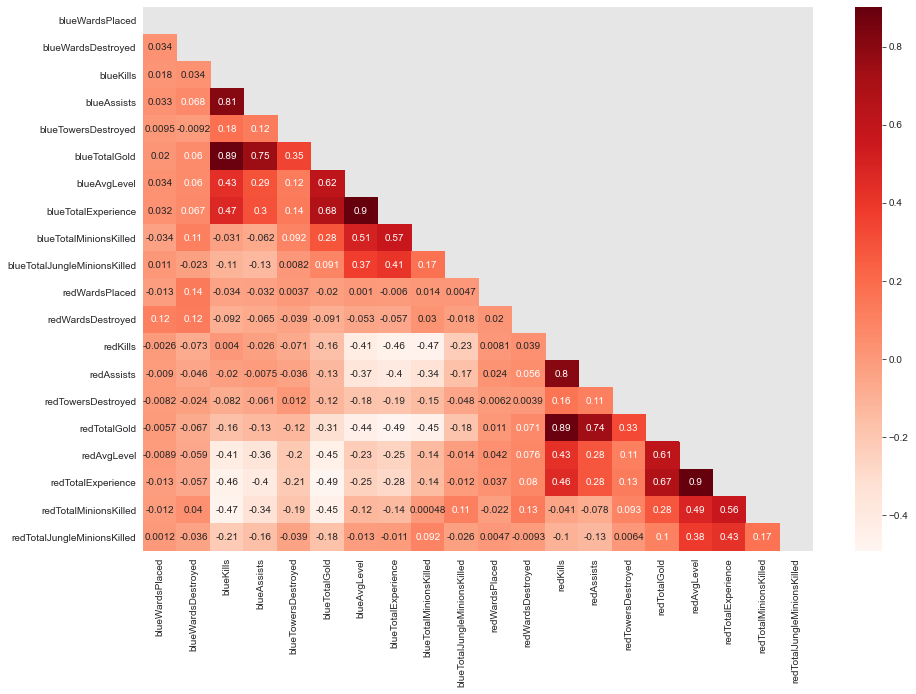

In [162]:
def heatmap(df_name, figsize=(15,10), cmap='Reds'):
    corr = df_name.drop('blueWins',axis=1).corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
    return fig, ax

heatmap(df)

In [163]:
# pd.set_option('display.max_rows', df.shape[0]+1)

# corr = df.drop('blueWins',axis=1).corr().abs()

# sort = corr.unstack()
# sort_order = sort.sort_values(kind="quicksort")

# corr_df = sort_order.to_frame()

# corr_features_df = corr_df[(corr_df[0] > 0.6) & (corr_df[0] < 1) ]

# corr_features_df.sort_values(by=0, ascending=False)

In [164]:
# https://pydatascience.org/2019/07/23/remove-duplicates-from-correlation-matrix-python/
def corr_list(df):
    dataCorr = df.drop('blueWins',axis=1).corr()

    dataCorr = dataCorr[abs(dataCorr) >= 0.01].stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]

    # filtering out lower/upper triangular duplicates 
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)

    return dataCorr.sort_values(by=[0], ascending=False).head(10) #Get 10 highest correlation of pairwaise attributes

corr_list(df)


,level_0,level_1,0
298,redAvgLevel,redTotalExperience,0.901748
113,blueAvgLevel,blueTotalExperience,0.901297
37,blueKills,blueTotalGold,0.888751
224,redKills,redTotalGold,0.885728
35,blueKills,blueAssists,0.813667
222,redKills,redAssists,0.804023
56,blueAssists,blueTotalGold,0.748352
242,redAssists,redTotalGold,0.736215
93,blueTotalGold,blueTotalExperience,0.676193
279,redTotalGold,redTotalExperience,0.669646


Our multicollinearity analysis has presented a few variable relationships that need additional consideration.

- avgLevel and TotalExperience are highly correlated, which is not surprising.  For now, we will stick with TotalExperience for blue and red teams since it's a bit more precise than AvgLevel.  However, we might want to run our baseline model with AvgLevel instead of TotalExperience to see if AvgLevel is more predictive.
- blue and red TotalGold appear consistently in our list.  This is also not surprising since kills and assists award gold.  We will remove gold for now.

In [165]:
corr_list(diff_df)

,level_0,level_1,0
64,AvgLevel,TotalExperience,0.919161
23,Kills,TotalGold,0.917008
54,TotalGold,TotalExperience,0.894729
53,TotalGold,AvgLevel,0.833493
21,Kills,Assists,0.830751
25,Kills,TotalExperience,0.822845
24,Kills,AvgLevel,0.766222
33,Assists,TotalGold,0.759321
55,TotalGold,TotalMinionsKilled,0.638765
75,TotalExperience,TotalMinionsKilled,0.625556


In [166]:
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,...,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,firstBlood,dragon,herald
0,0,28,2,9,11,0,17210,6.6,17039,195,...,8,0,16567,6.8,17047,197,55,Blue,No Dragon,No Herald
1,0,12,1,5,5,0,14712,6.6,16265,174,...,2,1,17620,6.8,17438,240,52,Red,Red,Red
2,0,15,0,7,4,0,16113,6.4,16221,186,...,14,0,17285,6.8,17254,203,28,Red,Blue,No Herald
3,0,43,1,4,5,0,15157,7.0,17954,201,...,10,0,16478,7.0,17961,235,47,Red,No Dragon,Blue
4,0,75,4,6,6,0,16400,7.0,18543,210,...,7,0,17404,7.0,18313,225,67,Red,Red,No Herald
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,7,5,0,17765,7.2,18967,211,...,7,0,15246,6.8,16498,229,34,Blue,Blue,No Herald
9875,1,54,0,6,8,0,16238,7.2,19255,233,...,3,0,15456,7.0,18367,206,56,Red,Blue,No Herald
9876,0,23,1,6,5,0,15903,7.0,18032,210,...,11,0,18319,7.4,19909,261,60,Red,Red,No Herald
9877,0,14,4,2,3,0,14459,6.6,17229,224,...,1,0,15298,7.2,18314,247,40,Blue,Blue,No Herald


In [167]:
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,...,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,firstBlood,dragon,herald
0,0,28,2,9,11,0,17210,6.6,17039,195,...,8,0,16567,6.8,17047,197,55,Blue,No Dragon,No Herald
1,0,12,1,5,5,0,14712,6.6,16265,174,...,2,1,17620,6.8,17438,240,52,Red,Red,Red
2,0,15,0,7,4,0,16113,6.4,16221,186,...,14,0,17285,6.8,17254,203,28,Red,Blue,No Herald
3,0,43,1,4,5,0,15157,7.0,17954,201,...,10,0,16478,7.0,17961,235,47,Red,No Dragon,Blue
4,0,75,4,6,6,0,16400,7.0,18543,210,...,7,0,17404,7.0,18313,225,67,Red,Red,No Herald
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,7,5,0,17765,7.2,18967,211,...,7,0,15246,6.8,16498,229,34,Blue,Blue,No Herald
9875,1,54,0,6,8,0,16238,7.2,19255,233,...,3,0,15456,7.0,18367,206,56,Red,Blue,No Herald
9876,0,23,1,6,5,0,15903,7.0,18032,210,...,11,0,18319,7.4,19909,261,60,Red,Red,No Herald
9877,0,14,4,2,3,0,14459,6.6,17229,224,...,1,0,15298,7.2,18314,247,40,Blue,Blue,No Herald


# MODEL

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

## Train Test Split

In [197]:
def tt_split_df(df):
    
    y = df['blueWins']
    X = df.drop(columns=['blueWins'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()
    
    categoricals = X.select_dtypes('O').columns
    numericals = X.select_dtypes('number').columns
    
    encoder = OneHotEncoder(sparse=False,drop='if_binary')
    train_categoricals = encoder.fit_transform(X_train_tf[categoricals])
    test_categoricals = encoder.transform(X_test_tf[categoricals])
    
    train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

    test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))
    train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train_tf[numericals]),
                              columns=numericals)

    test_numericals_df = pd.DataFrame(scaler.transform(X_test_tf[numericals]),
                              columns=numericals)
    
    X_train_tf = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
    X_test_tf = pd.concat([test_numericals_df, test_categoricals_df], axis=1)
    
    return X_train_tf, X_test_tf, y_train, y_test

tt_split_df(diff_df)

X_train, X_test, y_train, y_test = tt_split_df(diff_df)

X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_df)


In [200]:
X_train_tf


,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,0.037903,0.307443,0.223624,-0.512685,-0.032848,0.199359,0.433134,0.621114,0.740227,0.266309,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3.406620,-0.039258,-0.971398,-0.685885,-0.032848,-1.086553,-0.820579,-0.708206,-1.343285,0.683604,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.199530,1.694248,0.940637,0.526511,-0.032848,0.490980,0.015229,-0.074255,0.544898,-2.863406,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.194422,-0.385959,-0.254385,-0.166287,-0.032848,-0.167928,0.015229,-0.011797,-0.171310,0.683604,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.037903,-0.385959,1.179641,0.872910,-0.032848,0.257029,0.015229,0.193795,-1.440950,0.822702,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6910,0.773600,0.654144,-0.493389,0.180112,-0.032848,-0.579796,-0.820579,-0.364686,-0.529413,-1.889717,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6911,0.115345,-0.039258,0.223624,0.006913,-0.032848,0.485254,1.268943,0.996384,0.154239,0.266309,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6912,0.308949,0.654144,0.462628,0.006913,-0.032848,0.976878,1.268943,1.153050,0.512343,2.422334,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6913,-0.000818,1.347547,0.462628,-0.166287,-0.032848,0.235351,-0.402675,0.268224,1.000666,-1.681069,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [170]:
# Identify features and target

y = df['blueWins']
X = df.drop(columns=['blueWins'], axis=1)

# Assign train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Confirm split

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6915, 23)
X_test shape: (2964, 23)


## Transforming X Train and Test

In [171]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

## Categorical Columns

In [172]:
categoricals = X.select_dtypes('O').columns
numericals = X.select_dtypes('number').columns
categoricals, numericals

(Index(['firstBlood', 'dragon', 'herald'], dtype='object'),
 Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists',
        'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
        'blueTotalExperience', 'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
        'redKills', 'redAssists', 'redTowersDestroyed', 'redTotalGold',
        'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
        'redTotalJungleMinionsKilled'],
       dtype='object'))

In [173]:
## Encode categorical columns, only drop if binary
encoder = OneHotEncoder(sparse=False,drop='if_binary')
train_categoricals = encoder.fit_transform(X_train_tf[categoricals])
test_categoricals = encoder.transform(X_test_tf[categoricals])
train_categoricals

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [174]:
train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

train_categoricals_df.head()

,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Numerical Columns

In [175]:
from sklearn.preprocessing import StandardScaler

scaler = scaler = StandardScaler()

train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train_tf[numericals]),
                              columns=numericals)

test_numericals_df = pd.DataFrame(scaler.transform(X_test_tf[numericals]),
                              columns=numericals)

train_numericals_df.head()

,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redKills,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,-0.518005,0.086957,0.601063,1.311839,-0.205707,1.658781,0.931990,0.776076,1.017450,-0.654092,-0.347591,-0.337681,-1.070222,-0.658842,-0.190509,-0.994335,-0.413053,-0.870668,0.493467,-0.220934
1,-0.124915,-0.379175,0.934827,0.819779,-0.205707,1.176318,0.931990,0.302246,0.515128,1.378783,-0.401619,0.129238,-0.045021,0.333187,-0.190509,-0.386964,0.244617,-0.523018,-0.691400,-1.114827
2,-0.349538,-1.311440,-1.735279,-1.394489,-0.205707,-2.431667,-3.704015,-3.380857,-1.722491,-1.467242,-0.509675,-0.337681,3.372315,2.317243,4.617405,2.822460,0.902287,1.075669,0.265608,-0.717541
3,-0.349538,-0.845308,0.267300,1.065809,-0.205707,0.688610,-0.392583,-0.409339,1.108782,-0.247517,-0.239535,0.596157,0.638446,0.581194,-0.190509,0.798116,-0.413053,0.740555,0.675754,-0.121613
4,-0.012604,1.019223,2.269879,3.526106,-0.205707,2.543078,0.269703,0.569405,0.697790,-1.568885,-0.239535,0.596157,-1.070222,-0.658842,-0.190509,-1.194545,-1.728392,-1.274309,-0.964830,-0.320256


In [176]:
X_train_tf = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
X_test_tf = pd.concat([test_numericals_df, test_categoricals_df], axis=1)

X_train_tf.head()

,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,...,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,-0.518005,0.086957,0.601063,1.311839,-0.205707,1.658781,0.931990,0.776076,1.017450,-0.654092,...,-0.870668,0.493467,-0.220934,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.124915,-0.379175,0.934827,0.819779,-0.205707,1.176318,0.931990,0.302246,0.515128,1.378783,...,-0.523018,-0.691400,-1.114827,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.349538,-1.311440,-1.735279,-1.394489,-0.205707,-2.431667,-3.704015,-3.380857,-1.722491,-1.467242,...,1.075669,0.265608,-0.717541,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.349538,-0.845308,0.267300,1.065809,-0.205707,0.688610,-0.392583,-0.409339,1.108782,-0.247517,...,0.740555,0.675754,-0.121613,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.012604,1.019223,2.269879,3.526106,-0.205707,2.543078,0.269703,0.569405,0.697790,-1.568885,...,-1.274309,-0.964830,-0.320256,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Logistic Regression

In [177]:
model_log = LogisticRegression()

model_log.fit(X_train_tf, y_train)

# scores = cross_val_score(model_lr, X_train,y_train, cv=10) # model, train, target, cross validation



<bound method IndexOpsMixin.value_counts of 3636    1
8347    1
1386    0
1487    0
548     1
       ..
2730    0
7687    0
6134    0
8486    1
8968    0
Name: blueWins, Length: 6915, dtype: int64>

In [178]:
y_train.value_counts(1)

1    0.501374
0    0.498626
Name: blueWins, dtype: float64

In [180]:
y_test.value_counts(1)

0    0.50641
1    0.49359
Name: blueWins, dtype: float64

In [122]:
print(f"Training Score:\t{model_log.score(X_train_tf,y_train):.2f}")
print(f"Test Score:\t{model_log.score(X_test_tf,y_test):.2f}")



Training Score:	0.74
Test Score:	0.72


In [123]:
from sklearn.metrics import roc_curve, auc

# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train_tf)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_score = model_log.decision_function(X_test_tf)

# Calculate the fpr, tpr, and thresholds for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_score)

TO DO

get a better understanding of above
change graph below, add AUC to legend and show which line is which
make axes less numbers

AUC: 0.8157229131041368


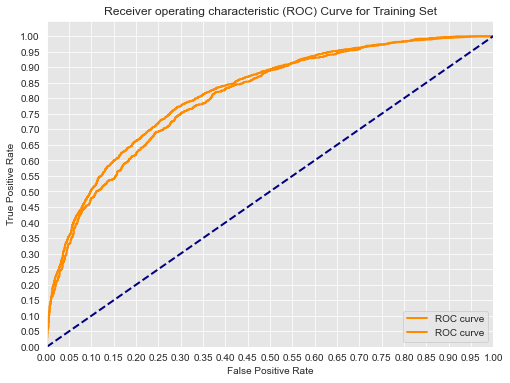

In [124]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

Test AUC: 0.8018065846225856



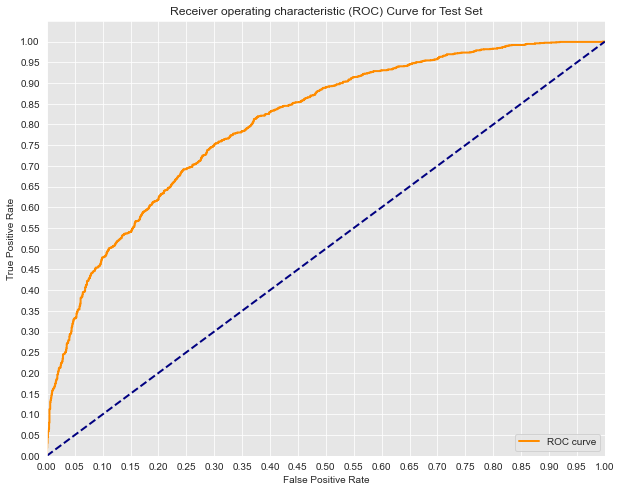

In [125]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

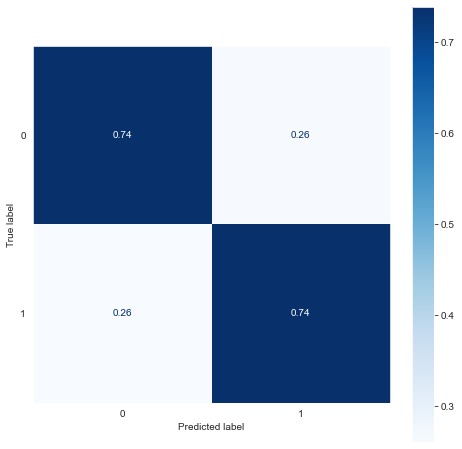

In [187]:
plot_cm(model_log)

In [ ]:
print(classification_report(y_test, dt_pred))

### Coefficients

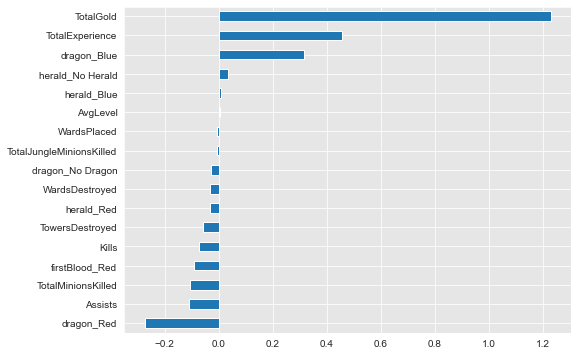

In [207]:
# diff_nogold_df = diff_df.drop(['TotalGold'],axis=1)

X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_df)

model_log = LogisticRegression()

model_log.fit(X_train_tf, y_train)

coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))

In [208]:
coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))



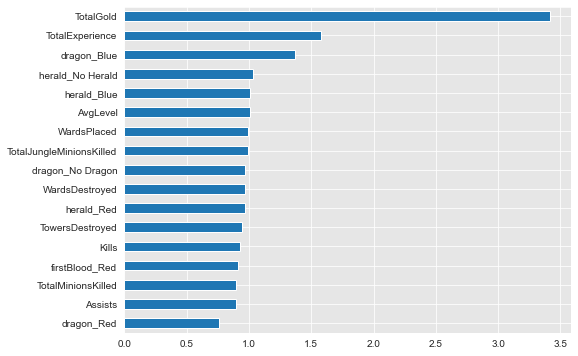

In [209]:
odds = np.exp(coef_lr)
ax = odds.plot(kind='barh', figsize=(8,6))

# np.exp(coef_lr)

For every 1 sd increase in Kills, the odds that blue wins is are 3.0 x as large as the odds that they lost

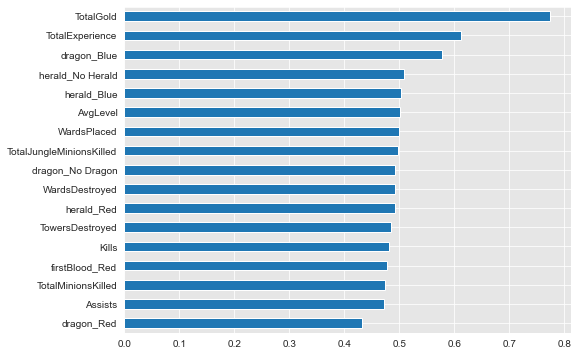

In [210]:
prob = odds/(1+odds)
prob

ax = prob.plot(kind='barh', figsize=(8,6))

In [211]:
def get_coefficients(model,X_train,units = "log-odds"):
    """Returns model coefficients. 
    
    Args:
        model: sklearn model with the .coef_ attribute. 
        X_train: dataframe with the feature names as the .columns
        units (str): Can be ['log-odds','odds','prob']
        """
    options = ['log-odds','odds','prob']
    
    if units not in options:
        raise Exception(f'units must be one of {options}')
        
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    
    if units=='odds':
        coeffs = np.exp(coeffs)
        
    elif units=='prob':
        coeffs = np.exp(coeffs)
        coeffs = coeffs/(1+coeffs)
        

    coeffs.name=units
    return coeffs

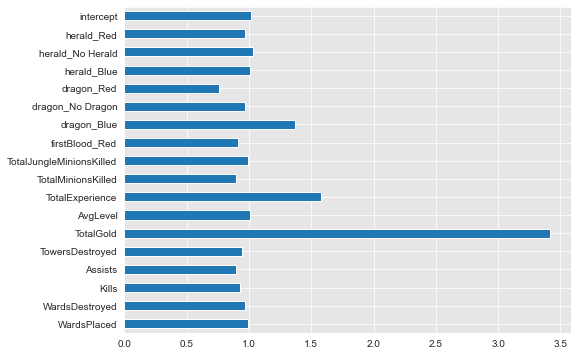

In [212]:
coeffs_odds = get_coefficients(model_log,X_train_tf,units='odds')
coeffs_odds

ax = coeffs_odds.plot(kind='barh', figsize=(8,6))

In [213]:
diff_nogold_df = diff_df.drop(['TotalGold'],axis=1)

X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_nogold_df)

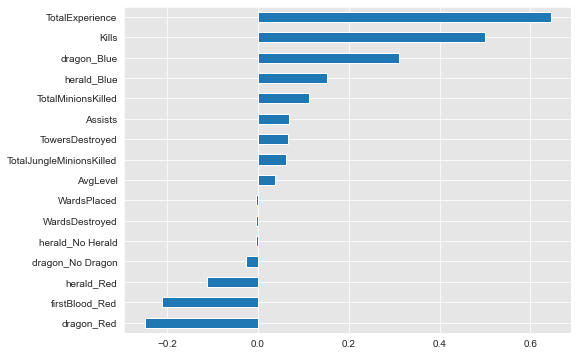

In [214]:
model_log = LogisticRegression()

model_log.fit(X_train_tf, y_train)

coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))

In [215]:
diff_nogold_noexp_df = diff_df.drop(['TotalGold', 'TotalExperience'],axis=1)

X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_nogold_noexp_df)

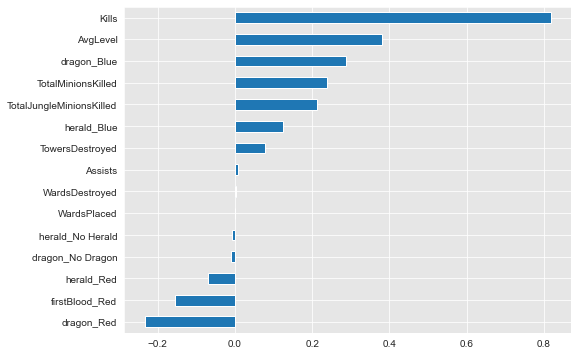

In [216]:
model_log = LogisticRegression()

model_log.fit(X_train_tf, y_train)

coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))

In [259]:
diff_nogold_noexp_no_avglvl_df = diff_df.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)

X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_nogold_noexp_no_avglvl_df)

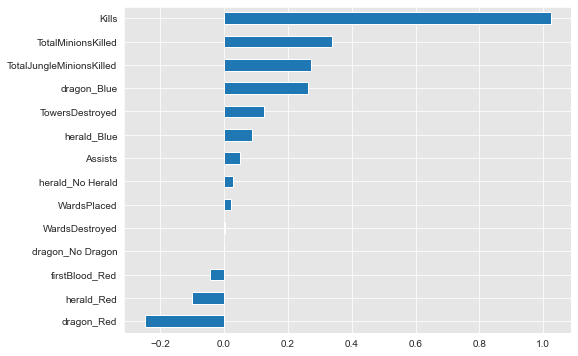

In [260]:
X_train_tf, X_test_tf, y_train, y_test = tt_split_df(diff_nogold_noexp_no_avglvl_df)

model_log = LogisticRegression()

model_log.fit(X_train_tf, y_train)

coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))

## Average log reg coefficients data 100 times to get this right

## Cross validation - if the spreads on the accuracies are too wide, then that would indicate that we need to tune the parameters of our model

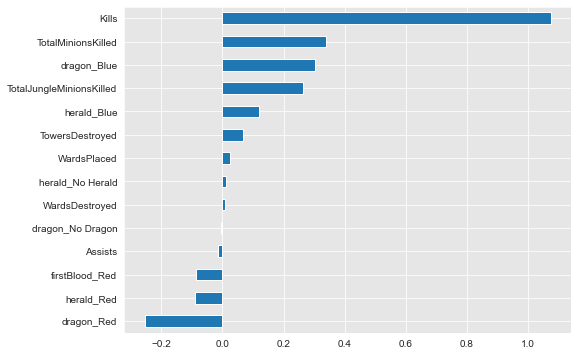

In [242]:
coef_lr = pd.Series(model_log.coef_.flatten(), index=X_train_tf.columns).sort_values(ascending=True)

ax = coef_lr.plot(kind='barh', figsize=(8,6))



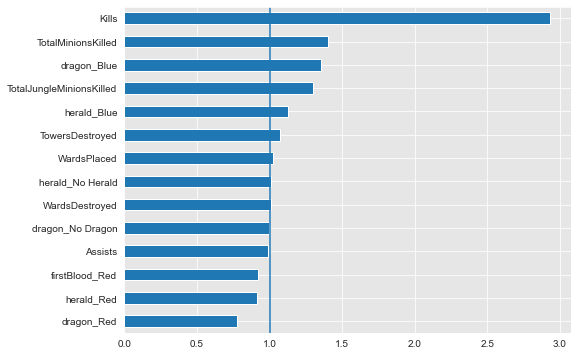

In [243]:
odds = np.exp(coef_lr)
ax = odds.plot(kind='barh', figsize=(8,6))
ax.axvline(1)
# np.exp(coef_lr)

For every 1 sd increase in Kills, the odds that blue wins is are 3.0 x as large as the odds that they lost

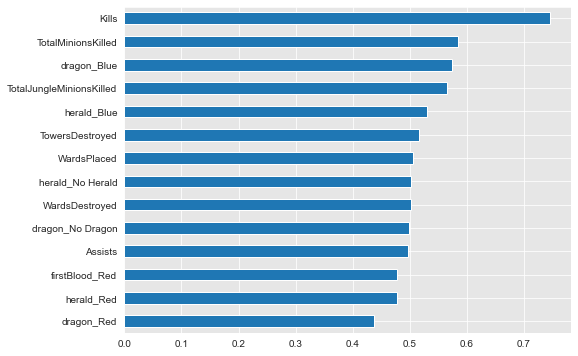

In [239]:
prob = odds/(1+odds)
prob

ax = prob.plot(kind='barh', figsize=(8,6))

In [240]:
def get_coefficients(model,X_train,units = "log-odds"):
    """Returns model coefficients. 
    
    Args:
        model: sklearn model with the .coef_ attribute. 
        X_train: dataframe with the feature names as the .columns
        units (str): Can be ['log-odds','odds','prob']
        """
    options = ['log-odds','odds','prob']
    
    if units not in options:
        raise Exception(f'units must be one of {options}')
        
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    
    if units=='odds':
        coeffs = np.exp(coeffs)
        
    elif units=='prob':
        coeffs = np.exp(coeffs)
        coeffs = coeffs/(1+coeffs)
        

    coeffs.name=units
    return coeffs

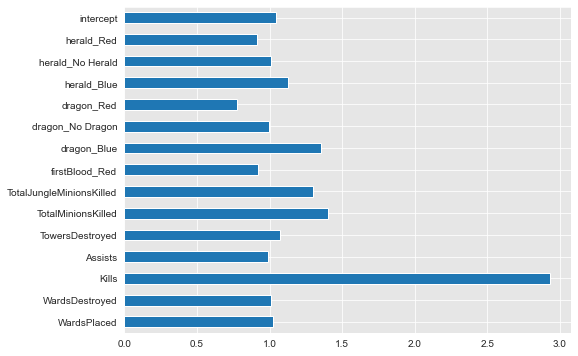

In [241]:
coeffs_odds = get_coefficients(model_log,X_train_tf,units='odds')
coeffs_odds

ax = coeffs_odds.plot(kind='barh', figsize=(8,6))

TO DO

https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_25_logistic_regression/topic_25_pt2_LogisticRegression_titanic-v2-SG.ipynb

Ctrl+F 'odds' to interpret coefficients

ALSO

Confusion Matrix



## Decision Trees

In [189]:
X_train = X_train_tf
X_test = X_test_tf

# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(X_train, y_train)

# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

DecisionTreeClassifier(max_depth=5)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1501
           1       0.74      0.67      0.71      1463

    accuracy                           0.72      2964
   macro avg       0.73      0.72      0.72      2964
weighted avg       0.73      0.72      0.72      2964



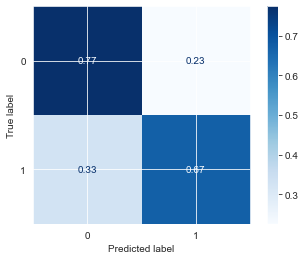

In [196]:
from sklearn.metrics import confusion_matrix

# Test set predictions
dt_pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(plot_confusion_matrix(tree_clf, X_test, y_test, normalize='true', cmap='Blues'))
print(classification_report(y_test, dt_pred))

In [191]:
tree_clf.score(X_train, y_train)

0.7295733911785972

In [ ]:
tree_clf.score(X_test, y_test)

In [ ]:
plot_cm(tree_clf)

In [ ]:
print_metrics(y_test, dt_pred)

In [ ]:
tree_clf

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, tree_clf.feature_importances_)

### To Do - repeat tree classifier but drop gold

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Imports for visualizing trees
from sklearn.tree import plot_tree,export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data


## Plot_tree from sklearn
fig,ax = plt.subplots(figsize=(60,25))
plot_tree(tree_clf,filled=True,rounded=True,proportion=True,
          feature_names=X_train.columns,
          class_names=['Lost','Won'],ax=ax);
fig.tight_layout()
# fig.savefig('titanic_tree.pdf', dpi=300,orientation='landscape')

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

In [ ]:
## Modified version of our simple eval function from Topic 25 Part 2 Study Group
# - Added X_train and y_train for if we want scores for both train and test
def evaluate_classification(model, X_test_tf,y_test,cmap='Reds',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model ([type]): [description]
        X_test_tf ([type]): [description]
        y_test ([type]): [description]
        cmap (str, optional): [description]. Defaults to 'Reds'.
        normalize (str, optional): [description]. Defaults to 'true'.
        classes ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (8,4).
        X_train ([type], optional): [description]. Defaults to None.
        y_train ([type], optional): [description]. Defaults to None.
    """
    

    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
        
        
def evaluate_grid(grid,X_test,y_test,X_train=None,y_train=None):
    print('The best parameters were:')
    print("\t",grid.best_params_)
    
    model = grid.best_estimator_    

    print('\n[i] Classification Report')
    evaluate_classification(model, X_test,y_test,X_train=X_train,y_train=y_train)

In [ ]:
## Set up param grid
params = {'max_depth':[None,3,5,10],
         'min_samples_leaf':[1,2,3,5],
         'criterion':['entropy','ginie']}


## Instantiate & Fit GridSearchCV
gridsearch = GridSearchCV(DecisionTreeClassifier(),params,n_jobs=-1)
gridsearch.fit(X_train,y_train)
## Evaluate with our function
evaluate_grid(gridsearch,X_test,y_test,X_train=X_train,y_train=y_train)

## Random Forest

In [ ]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
forest.fit(X_train, y_train)

# scores = cross_val_score(model_xgb, X_train,y_train, cv=10) # model, train, target, cross validation

# Predict on training and test sets
training_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# print('cross-val-score \n{}'.format(scores))
# print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
# Training accuracy score
forest.score(X_train, y_train)

In [ ]:
# Test accuracy score
forest.score(X_test, y_test)

In [ ]:
# Test set predictions
rf_pred = forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

In [ ]:
plot_cm(forest)

In [ ]:
print_metrics(y_test, rf_pred)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, forest.feature_importances_)

In [ ]:
# model = RandomForestClassifier()

# rf_param_grid = {
#     'n_estimators': [10, 100, 1000],
#     'criterion': ['gini', 'entropy'],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [None, 2, 6, 10],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [3, 6]
# }

# # define grid search
# grid_rf = GridSearchCV(model, rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
# grid_rf.fit(X_train, y_train)

# best_parameters = grid_rf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds_rf = grid_rf.predict(X_train)
# test_preds_rf = grid_rf.predict(X_test)
# training_accuracy_rf = accuracy_score(y_train, training_preds_rf)
# test_accuracy_rf = accuracy_score(y_test, test_preds_rf)

# print('')
# print('Training Accuracy: {:.4}%'.format(training_accuracy_rf * 100))
# print('Testing Accuracy: {:.4}%'.format(test_accuracy_rf * 100))

## AdaBoost Classifier

In [ ]:
ada=AdaBoostClassifier()
ada.fit(X_train, y_train)
scores = cross_val_score(ada, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

In [ ]:
ypred = ada.predict(X_test)
print("Test Accuracy: {}%".format(round(ada.score(X_test, y_test)*100, 2)))
print("Random Forest Classifier report: \n\n", classification_report(y_test, ypred))

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, ada.feature_importances_)

## XGBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
# scores = cross_val_score(model_xgb, X_train,y_train, cv=10) # model, train, target, cross validation

# Predict on training and test sets
training_preds = model_xgb.predict(X_train)
test_preds = model_xgb.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# print('cross-val-score \n{}'.format(scores))
# print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
pred = model_xgb.predict(X_test)
print("Test Accuracy: {}%".format(round(model_xgb.score(X_test, y_test)*100, 2)))

print(classification_report(y_test, pred))

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, model_xgb.feature_importances_)

In [ ]:
plot_cm(model_xgb)

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000],
}

In [ ]:
model_xgb = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
model_xgb.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

# SCRATCH

## Grid Search Logistic Regression

In [ ]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [ ]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# model = LogisticRegression()

# log_param_grid = {
#     'solver': ['newton-cg', 'lbfgs', 'liblinear'],
#     'penalty': ['l2'],
#     'C': [100, 10, 1.0, 0.1, 0.01, 1e12],
#     'class_weight': [None, 'balanced'],
#     'max_iter': [10000],
#     'fit_intercept': [False] }

# # define grid search
# grid_log = GridSearchCV(model, log_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
# grid_log.fit(X_train_tf, y_train)

# best_parameters = grid_log.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds_log = grid_log.predict(X_train_tf)
# test_preds_log = grid_log.predict(X_test_tf)
# training_accuracy_log = accuracy_score(y_train, training_preds_log)
# test_accuracy_log = accuracy_score(y_test, test_preds_log)

# print('')
# print('Training Accuracy: {:.4}%'.format(training_accuracy_log * 100))
# print('Testing Accuracy: {:.4}%'.format(test_accuracy_log * 100))

In [ ]:
# print_metrics(y_test, test_preds_log)

In [ ]:
# test_preds_log

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:

# ## make gridseach
# log_reg = LogisticRegression()
# params = {'C':[0.001, 0.01, 0.1, 1, 10, 100,1e6,1e12],
#         'penalty':['l1','l2','elastic_net'],
#         'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],}
# gridsearch = GridSearchCV(log_reg,params,)
# gridsearch

In [ ]:
# ## fit grid and show best_params
# gridsearch.fit(X_train_tf, y_train)
# gridsearch.best_params_

In [ ]:
# ## get best_esinmtaor_
# gridsearch.best_estimator_